# Introduction

### Business Problem: A recent graduate is offered a job by Google, but he/she has to pick between various Google Office Branches. I will use my own personal experience as well as machine learning to develope a decision tree to help people select which location they are suited for.

### Target Audience: Recent graduates and anyone that is offered a job by Google.

# Data

## Foursquare location data will be used, as well as online data sets that contain data about all cities such as crime rate, cost of living, and average salary. Online data will be captured manually, and Foursquare location data will be captured using the Foursquare API.

### The first step is to import all of the necessary packages

In [1]:
#Importing packages
import pandas as pd
import numpy as np

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium 

# getting latitude and longitude coordinates
from geopy.geocoders import Nominatim

# Decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

#Decision Tree Visualization
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### The next step is to use the Foursquare API to gather location data about nearby venues of all locations.

In [49]:
#I will first get the latitude and longitude of all locations.

geolocator = Nominatim(user_agent="Coursera_Capstone")

NY_location = geolocator.geocode("111 8th Avenue, New York, New York")
NY_latitude = NY_location.latitude
NY_longitude = NY_location.longitude

CA_location = geolocator.geocode('1600 Amphitheatre Parkway, California')
CA_latitude = CA_location.latitude
CA_longitude = CA_location.longitude

TX_location = geolocator.geocode('500 W 2nd St, Texas')
TX_latitude = TX_location.latitude
TX_longitude = TX_location.longitude

GA_location = geolocator.geocode('10 10th Street NE, Georgia')
GA_latitude = GA_location.latitude
GA_longitude = GA_location.longitude

MA_location = geolocator.geocode('355 Main Street, Cambridge, MA')
MA_latitude = MA_location.latitude
MA_longitude = MA_location.longitude

MI_location = geolocator.geocode('1450 Brickell Ave, Miami, Florida')
MI_latitude = MI_location.latitude
MI_longitude = MI_location.longitude

CO_location = geolocator.geocode('2600 Pearl Street, Boulder, Colorado')
CO_latitude = CO_location.latitude
CO_longitude = CO_location.longitude

NC_location = geolocator.geocode('200 West Franklin Street, Chapel Hill, North Carolina')
NC_latitude = NC_location.latitude
NC_longitude = NC_location.longitude

VA_location = geolocator.geocode('1875 Explorer Street, Reston, Virginia')
VA_latitude = VA_location.latitude
VA_longitude = VA_location.longitude

WA_location = geolocator.geocode('601 N. 34th Street, Seattle, Washington')
WA_latitude = WA_location.latitude
WA_longitude = WA_location.longitude




#Creating a dataframe to hold all of this information
df = pd.DataFrame(columns = ['Name', 'Latitude', 'Longitude'])
df['Name'] = ['Google_NY', 'Google_CA', 'Google_TX', 'Google_GA', 'Google_MA', 'Google_MI', 'Google_CO', 'Google_NC', 'Google_VA', 'Google_WA']
df['Latitude'] = [NY_latitude, CA_latitude, TX_latitude, GA_latitude, MA_latitude, MI_latitude, CO_latitude, NC_latitude, VA_latitude, WA_latitude]
df['Longitude'] = [NY_longitude, CA_longitude, TX_longitude, GA_longitude, MA_longitude, MI_longitude, CO_longitude, NC_longitude, VA_longitude, WA_longitude]

df.head()

,Name,Latitude,Longitude
0,Google_NY,40.740874,-74.002056
1,Google_CA,37.421764,-122.084614
2,Google_TX,30.265984,-97.749341
3,Google_GA,33.782292,-84.387183
4,Google_MA,42.362772,-71.087257


### I will now get the information from Foursquare.
### I will limit my search to 100 locations and 500 meters around all buildings, which is a very walkable distance.

In [50]:
#Initial Parameters
CLIENT_ID = 'DV5VFHJJVSUEUHTFVTDQXDCKZ23KG2Q4SCUKFOMJLKSSMX1H' 
CLIENT_SECRET = '0LHT1ZVBUHGHHIJS323EHDBDGBXUKTQMBSAVINOZOZG5LFXM' 
VERSION = '20180605'
LIMIT = 100
radius = 500

In [51]:
#Using a function to get the information from Foursquare

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Location Latitude', 
                  'Location Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [52]:
Google = getNearbyVenues(names=df['Name'], latitudes=df['Latitude'], longitudes=df['Longitude'])

Google_NY
Google_CA
Google_TX
Google_GA
Google_MA
Google_MI
Google_CO
Google_NC
Google_VA
Google_WA


## Now, since all the locations are walking distance, I will delete the venue latitude and longitude. I will also delete the Venue name, and remove any duplicate Venue Categories, as one venue being present is enough for my taste. I will also clean up the dataframe so it is more readable.

In [53]:
Google_clean = Google.drop(['Venue', 'Venue Latitude', 'Venue Longitude'], axis = 1)

Google_clean = Google_clean.drop_duplicates(subset=['Location', 'Venue Category'])

Google_onehot = pd.get_dummies(Google_clean[['Venue Category']], prefix="", prefix_sep="")

Google_onehot['Location'] = Google_clean['Location'] 

Google_onehot = Google_onehot.set_index('Location').reset_index()

Google_grouped = Google_onehot.groupby('Location').sum().reset_index()

### From personal experience of visiting all locations, I remember which locations I liked best due to the surrounding venues, and I will add that information in as well as add in average crime rate, average salary, and average cost of living.

In [111]:
#These numbers were gathered from various internet sources.

Google_grouped['My Preference'] = ['Would like to work here', 'Would NOT like to work here', 'Would NOT like to work here', 'Would NOT like to work here', 'Would like to work here', 'Would NOT like to work here', 'Would like to work here', 'Would NOT like to work here', 'Would NOT like to work here', 'Would like to work here']
Google_grouped['Average Salary (yearly)'] = [115000, 71000, 66000, 86000, 61000, 57000, 75000, 68000, 83000, 78000]
Google_grouped['Average Cost of Living (median rent)'] = [3593, 1227, 1026, 3474, 1563, 1102, 5100, 1107, 2206, 2111]
Google_grouped['Avearage Crime Rate (crime index)'] = [18, 7, 2, 19, 7, 40, 23, 8, 39, 2]

### Now I will begin to create my decision tree. I won't be able to do any train/test split since I don't have that much data, but I will still be able to create this tree, and hopefully it will still provide some context.

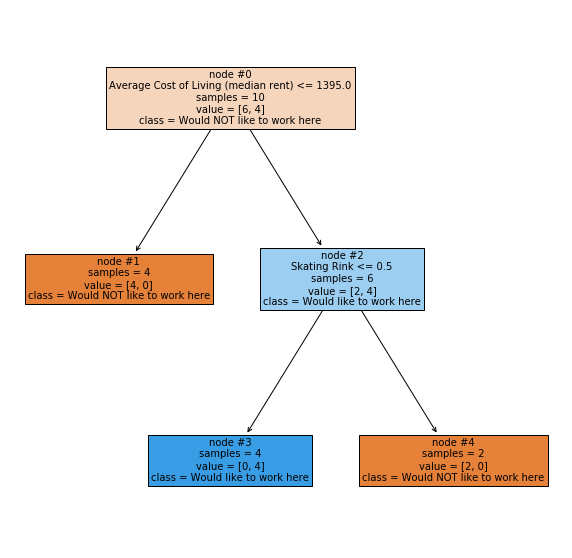

In [115]:
X = Google_grouped.drop(['Location', 'My Preference'], axis = 1).values
Y = Google_grouped['My Preference']
plt.figure(figsize = (10,10))
GoogleTree = DecisionTreeClassifier(criterion = "entropy", max_depth = 4)
GoogleTree.fit(X, Y)
plot_tree(GoogleTree, filled = True, feature_names = Google_grouped.drop(['Location', 'My Preference'], axis = 1).columns, class_names= np.unique(Y), node_ids = True, impurity = False, fontsize = 10)
plt.show()

# Methodology

### I used a supervised machine learning technique, Decision Trees, to build my classifier. Due to the small sample size, I do not think it is prudent to do a train/test split. However, given a proper sample size (i.e. I actually visited many more google locations) then I would do the following:
### Do a train/test split, and calculate the accuracy of my model using a Confusion Matrix.

# Results

### Since the decision tree does not always result in the same tree, I have run the classifier numerous times and it is safe to assume that for this project that this is the optimal tree.
### From the tree, we can see the first split occurs at the Average Cost of Living. So if the Average Cost of Living is indeed <= 1395.0 (monthly rent) then I would not like to work there. 
### If the location in question has a monthly rent of > 1395.0, then we can proceed to the next node.
### Now, if the location does contain a Skating Rink, I would not like to work there. If the location does not, then I would like to work there. The main distinctive features that are shown is the median rent and the presence of a Skating Rink.

# Discussion

### To reiterate, this tree could be made more robust with the inclusion of more data. However, to keep it realistic, I only included locations that I have actually personally visited. According to my tree, if someone my age is deciding between various Google office locations, then I would recommend them to look at the median rent as well as the presence of a Skating Rink.

### I cannot be sure about the explanations behind this phenomena, but I can assume that I prefer high-rent areas due to the increased safety and quality of goods and services. I can also assume that I do not prefer Skating Rinks due to the crowd they typically attract (Skating Rinks are known to attract families and older individuals).

# Conclusion

### In conclusion, I have used personal experience, Foursquare location data, online sources, and supervised machine learning to create a Decision Tree Classifier to help recent graduates select a Google location to work for.
### This classifier has concluded that to find the best location, one must look at the median rent and the presence of a Skating Rink.
### In future work, to make the classifier more robust, I should visit more Google office locations, as well as add additional online data from various other online sources / API's.